In [82]:
#! pip install grad-cam timm

In [83]:
import os
import cv2
import numpy as np
import pandas as pd
from math import ceil
from time import time
from skimage import color
from tqdm.auto import tqdm
import multiprocessing as mp
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import timm
import torch
import torchvision
import torchsummary
from torch import nn
from torch.optim import Adam
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
#from torch.utils.tensorboard import SummaryWriter

from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, EigenGradCAM, LayerCAM, FullGrad

%matplotlib inline

In [84]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [85]:
valid_img_path = '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Dataset/WSSS4LUAD/2.validation/2.validation/img/00.png'
valid_mak_path = '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Dataset/WSSS4LUAD/2.validation/2.validation/mask/00.png'

In [86]:
valid_img = cv2.resize(cv2.imread(valid_img_path), (224, 224))
valid_mask = cv2.resize(cv2.imread(valid_mak_path), (224, 224))

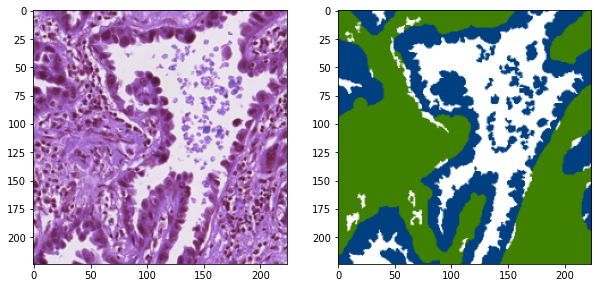

In [87]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(1, 2, 1)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(valid_mask, cv2.COLOR_BGR2RGB))

In [88]:
def preprocess_image(img: np.ndarray, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], resized = (224, 224)) -> torch.Tensor:
  
  preprocessing = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Resize((224, 224)),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                      ])
  return preprocessing(img.copy()).unsqueeze(0)


In [89]:
def reshape_transform(tensor, height=14, width=14):
  result = tensor[:, 1 :  , :].reshape(tensor.size(0),
                                       height, width, tensor.size(2))
  
  # Bring the channels to the first dimension,
  # like in CNNs.
  result = result.transpose(2, 3).transpose(1, 2)
  return result

In [90]:
model_weights = ['/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models/' + x for x in os.listdir('/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models') if '16' in x and 'deit' not in x]
model_weights.sort()
model_weights

['/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models/accu_cutmix_aug_model_vit_base_patch16_224_01.pth',
 '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models/border_cutmix_model_vit_base_patch16_224_01.pth',
 '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models/border_cutmix_model_vit_base_patch16_224_02.pth',
 '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models/cutmix_model_vit_base_patch16_224_01.pth',
 '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models/model_vit_base_patch16_224_1.pth']

# Model 0: model_vit_16_224_1.pth

In [140]:
model_vit_base_patch16_224 = timm.create_model('vit_base_patch16_224', pretrained = True, num_classes = 3,
                                               drop_rate = 0.2, attn_drop_rate = 0.2).to(device)

model_vit_base_patch16_224.load_state_dict(torch.load(f=model_weights[1], map_location=device))

<All keys matched successfully>

In [141]:
%%capture
model_vit_base_patch16_224.eval()

In [142]:
target_layer = [model_vit_base_patch16_224.blocks[-1].norm1]
target_layer

[LayerNorm((768,), eps=1e-06, elementwise_affine=True)]

In [143]:
valid_img_tensor = preprocess_image(valid_img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]).to(device)

## 01. GradCAM: img 0

In [144]:
cam = GradCAM(model = model_vit_base_patch16_224, target_layers=target_layer,
              reshape_transform=reshape_transform)

### Class 0: Tumor

In [145]:
valid_cam_0 = cam(input_tensor=valid_img_tensor, targets=[ClassifierOutputTarget(np.array([0]))])
valid_cam_1 = cam(input_tensor=valid_img_tensor, targets=[ClassifierOutputTarget(np.array([1]))])
valid_cam_2 = cam(input_tensor=valid_img_tensor, targets=[ClassifierOutputTarget(np.array([2]))])

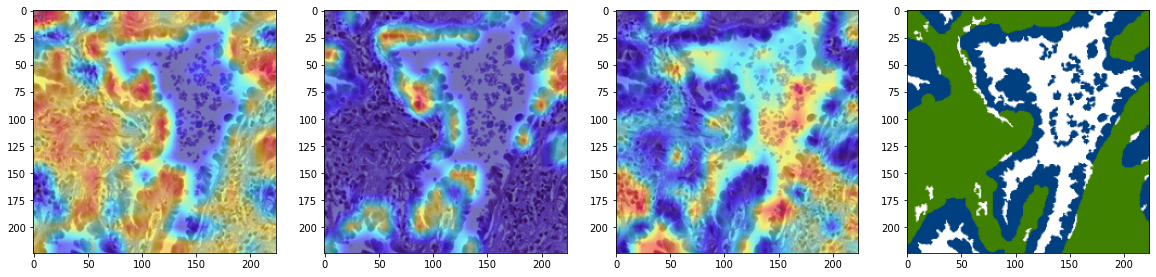

In [146]:
fig = plt.figure(figsize=(20, 40))
'''
ax = fig.add_subplot(1, 4, 1)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 4, 2)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 4, 3)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 4, 4)
plt.imshow(valid_img)
'''
ax = fig.add_subplot(1, 4, 1)
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_0[0, :], use_rgb=True))

ax = fig.add_subplot(1, 4, 2)
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_1[0, :], use_rgb=True))

ax = fig.add_subplot(1, 4, 3)
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_2[0, :], use_rgb=True))

ax = fig.add_subplot(1, 4, 4)
plt.imshow(cv2.cvtColor(valid_mask, cv2.COLOR_BGR2RGB))

In [147]:
t_ls_0 = [x.norm1 for x in model_vit_base_patch16_224.blocks]
#t_ls_0

In [148]:
t_ls = [[x.norm1] for x in model_vit_base_patch16_224.blocks]
#t_ls

In [149]:
cams_0 = GradCAM(model = model_vit_base_patch16_224, target_layers=t_ls_0, reshape_transform=reshape_transform)

In [150]:
cams = [GradCAM(model = model_vit_base_patch16_224, target_layers=x, reshape_transform=reshape_transform) for x in t_ls]

In [151]:
test_cams = [x(input_tensor=valid_img_tensor, targets=[ClassifierOutputTarget(np.array([0]))]) for x in cams]
test_cams_0 = cams_0(input_tensor=valid_img_tensor, targets=[ClassifierOutputTarget(np.array([0]))])

KeyboardInterrupt: 

In [ ]:
test_cam_mean = np.mean(np.array(test_cams), axis = 0)
test_cam_sum = np.array(test_cams).sum(axis=0)

In [ ]:
test_cam_max = np.vstack(test_cams).max(axis=0)

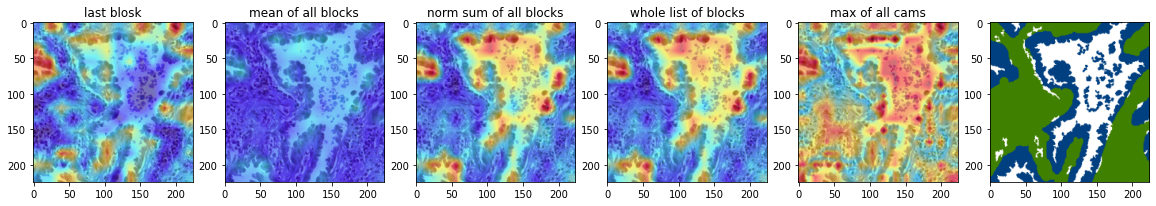

In [ ]:
fig = plt.figure(figsize=(20, 15))

ax = fig.add_subplot(2, 6, 1)
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_0[0, :], use_rgb=True))     # from just the last block
ax.set_title('last blosk')

ax = fig.add_subplot(2, 6, 2)
plt.imshow(show_cam_on_image(valid_img/255, test_cam_mean[0, :], use_rgb=True))   # mean of the cams from all blocks
ax.set_title('mean of all blocks')

ax = fig.add_subplot(2, 6, 3)
plt.imshow(show_cam_on_image(valid_img/255, ((test_cam_sum - np.min(test_cam_sum))/np.ptp(test_cam_sum))[0, :], use_rgb=True)) # Normalized sum of all cams
ax.set_title('norm sum of all blocks')

ax = fig.add_subplot(2, 6, 4)
plt.imshow(show_cam_on_image(valid_img/255, test_cams_0[0, :], use_rgb=True))     # passing the whole list of layers
ax.set_title('whole list of blocks')

ax = fig.add_subplot(2, 6, 5)
plt.imshow(show_cam_on_image(valid_img/255, test_cam_max, use_rgb=True))     # max of all cams
ax.set_title('max of all cams')

ax = fig.add_subplot(2, 6, 6)
plt.imshow(cv2.cvtColor(valid_mask, cv2.COLOR_BGR2RGB))

### Class 1: Stroma

In [ ]:
t_ls_0 = [x.norm1 for x in model_vit_base_patch16_224.blocks]
#t_ls_0

In [ ]:
t_ls = [[x.norm1] for x in model_vit_base_patch16_224.blocks]
#t_ls

In [ ]:
cams_0 = GradCAM(model = model_vit_base_patch16_224, target_layers=t_ls_0, reshape_transform=reshape_transform)

In [ ]:
cams = [GradCAM(model = model_vit_base_patch16_224, target_layers=x, reshape_transform=reshape_transform) for x in t_ls]

In [ ]:
test_cams = [x(input_tensor=valid_img_tensor, targets=[ClassifierOutputTarget(np.array([1]))]) for x in cams]
test_cams_0 = cams_0(input_tensor=valid_img_tensor, targets=[ClassifierOutputTarget(np.array([1]))])

In [ ]:
test_cam_mean = np.mean(np.array(test_cams), axis = 0)
test_cam_sum = np.array(test_cams).sum(axis=0)

In [ ]:
test_cam_max = np.vstack(test_cams).max(axis=0)

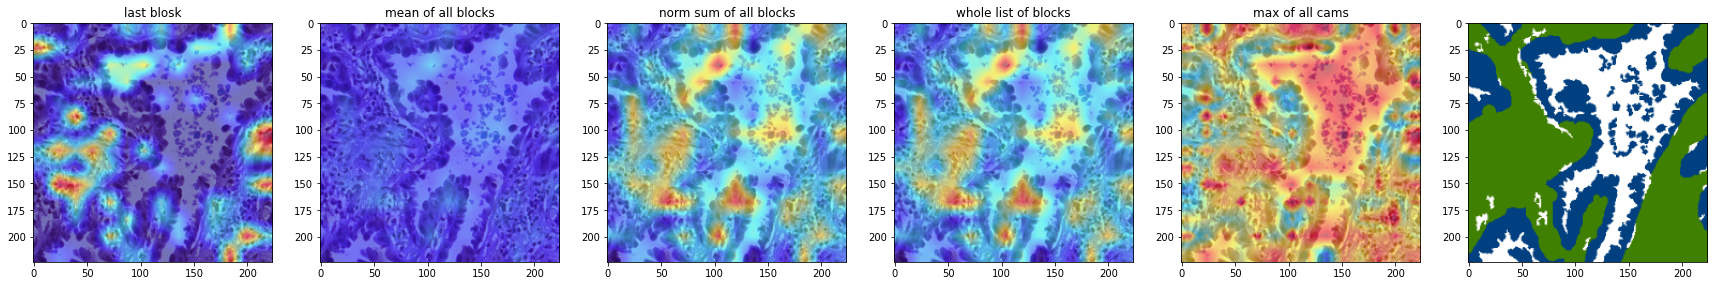

In [ ]:
fig = plt.figure(figsize=(30, 15))

ax = fig.add_subplot(2, 6, 1)
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_1[0, :], use_rgb=True))     # from just the last block
ax.set_title('last blosk')

ax = fig.add_subplot(2, 6, 2)
plt.imshow(show_cam_on_image(valid_img/255, test_cam_mean[0, :], use_rgb=True))   # mean of the cams from all blocks
ax.set_title('mean of all blocks')

ax = fig.add_subplot(2, 6, 3)
plt.imshow(show_cam_on_image(valid_img/255, ((test_cam_sum - np.min(test_cam_sum))/np.ptp(test_cam_sum))[0, :], use_rgb=True)) # Normalized sum of all cams
ax.set_title('norm sum of all blocks')

ax = fig.add_subplot(2, 6, 4)
plt.imshow(show_cam_on_image(valid_img/255, test_cams_0[0, :], use_rgb=True))     # passing the whole list of layers
ax.set_title('whole list of blocks')

ax = fig.add_subplot(2, 6, 5)
plt.imshow(show_cam_on_image(valid_img/255, test_cam_max, use_rgb=True))     # max of all cams
ax.set_title('max of all cams')

ax = fig.add_subplot(2, 6, 6)
plt.imshow(cv2.cvtColor(valid_mask, cv2.COLOR_BGR2RGB))

### Class 2: Normal

In [ ]:
t_ls_0 = [x.norm1 for x in model_vit_base_patch16_224.blocks]
#t_ls_0

In [ ]:
t_ls = [[x.norm1] for x in model_vit_base_patch16_224.blocks]
#t_ls

In [ ]:
cams_0 = GradCAM(model = model_vit_base_patch16_224, target_layers=t_ls_0, reshape_transform=reshape_transform)

In [ ]:
cams = [GradCAM(model = model_vit_base_patch16_224, target_layers=x, reshape_transform=reshape_transform) for x in t_ls]

In [ ]:
test_cams = [x(input_tensor=valid_img_tensor, targets=[ClassifierOutputTarget(np.array([2]))]) for x in cams]
test_cams_0 = cams_0(input_tensor=valid_img_tensor, targets=[ClassifierOutputTarget(np.array([2]))])

KeyboardInterrupt: 

In [ ]:
test_cam_mean = np.mean(np.array(test_cams), axis = 0)
test_cam_sum = np.array(test_cams).sum(axis=0)

In [ ]:
test_cam_max = np.vstack(test_cams).max(axis=0)

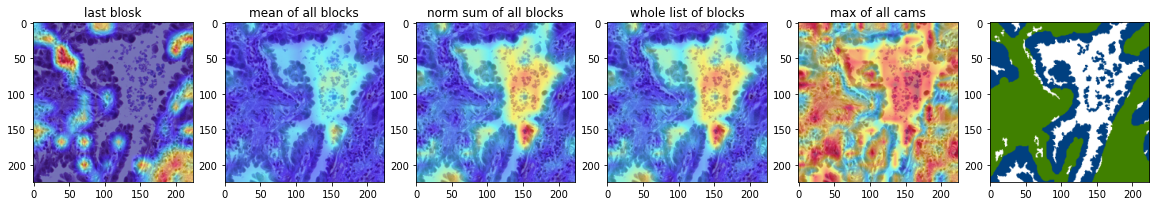

In [ ]:
fig = plt.figure(figsize=(20, 15))

ax = fig.add_subplot(2, 6, 1)
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_1[0, :], use_rgb=True))     # from just the last block
ax.set_title('last blosk')

ax = fig.add_subplot(2, 6, 2)
plt.imshow(show_cam_on_image(valid_img/255, test_cam_mean[0, :], use_rgb=True))   # mean of the cams from all blocks
ax.set_title('mean of all blocks')

ax = fig.add_subplot(2, 6, 3)
plt.imshow(show_cam_on_image(valid_img/255, ((test_cam_sum - np.min(test_cam_sum))/np.ptp(test_cam_sum))[0, :], use_rgb=True)) # Normalized sum of all cams
ax.set_title('norm sum of all blocks')

ax = fig.add_subplot(2, 6, 4)
plt.imshow(show_cam_on_image(valid_img/255, test_cams_0[0, :], use_rgb=True))     # passing the whole list of layers
ax.set_title('whole list of blocks')

ax = fig.add_subplot(2, 6, 5)
plt.imshow(show_cam_on_image(valid_img/255, test_cam_max, use_rgb=True))     # max of all cams
ax.set_title('max of all cams')

ax = fig.add_subplot(2, 6, 6)
plt.imshow(cv2.cvtColor(valid_mask, cv2.COLOR_BGR2RGB))

# imge 2

In [ ]:
valid_img_path = '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Dataset/WSSS4LUAD/2.validation/2.validation/img/01.png'
valid_mak_path = '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Dataset/WSSS4LUAD/2.validation/2.validation/mask/01.png'

In [ ]:
valid_img = cv2.resize(cv2.imread(valid_img_path), (224, 224))
valid_mask = cv2.resize(cv2.imread(valid_mak_path), (224, 224))

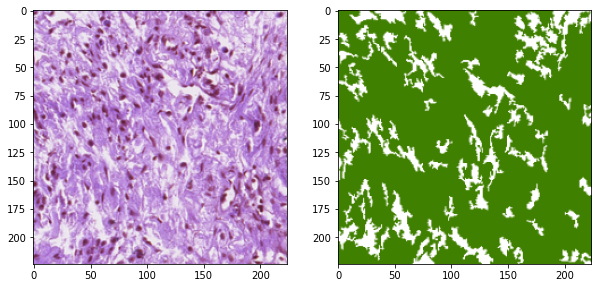

In [ ]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(1, 2, 1)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(valid_mask, cv2.COLOR_BGR2RGB))

In [ ]:
valid_img_tensor = preprocess_image(valid_img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]).to(device)

## 02. GradCAM: img 1

In [ ]:
cam = GradCAM(model = model_vit_base_patch16_224, target_layers=target_layer,
              reshape_transform=reshape_transform)

### Class 0: Tumor

In [ ]:
valid_cam_0 = cam(input_tensor=valid_img_tensor, targets=[ClassifierOutputTarget(np.array([0]))])
valid_cam_1 = cam(input_tensor=valid_img_tensor, targets=[ClassifierOutputTarget(np.array([1]))])
valid_cam_2 = cam(input_tensor=valid_img_tensor, targets=[ClassifierOutputTarget(np.array([2]))])

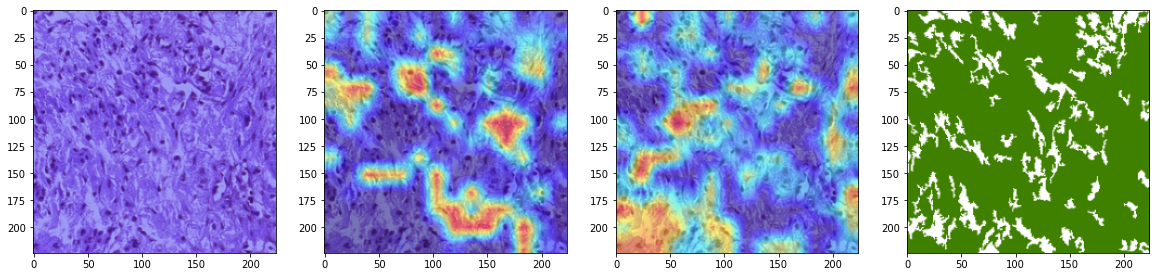

In [ ]:
fig = plt.figure(figsize=(20, 40))
'''
ax = fig.add_subplot(1, 4, 1)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 4, 2)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 4, 3)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 4, 4)
plt.imshow(valid_img)
'''
ax = fig.add_subplot(1, 4, 1)
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_0[0, :], use_rgb=True))

ax = fig.add_subplot(1, 4, 2)
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_1[0, :], use_rgb=True))

ax = fig.add_subplot(1, 4, 3)
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_2[0, :], use_rgb=True))

ax = fig.add_subplot(1, 4, 4)
plt.imshow(cv2.cvtColor(valid_mask, cv2.COLOR_BGR2RGB))

In [ ]:
t_ls_0 = [x.norm1 for x in model_vit_base_patch16_224.blocks]
#t_ls_0

In [ ]:
t_ls = [[x.norm1] for x in model_vit_base_patch16_224.blocks]
#t_ls

In [ ]:
cams_0 = GradCAM(model = model_vit_base_patch16_224, target_layers=t_ls_0, reshape_transform=reshape_transform)

In [ ]:
cams = [GradCAM(model = model_vit_base_patch16_224, target_layers=x, reshape_transform=reshape_transform) for x in t_ls]

In [ ]:
test_cams = [x(input_tensor=valid_img_tensor, targets=[ClassifierOutputTarget(np.array([0]))]) for x in cams]
test_cams_0 = cams_0(input_tensor=valid_img_tensor, targets=[ClassifierOutputTarget(np.array([0]))])

In [ ]:
test_cam_mean = np.mean(np.array(test_cams), axis = 0)
test_cam_sum = np.array(test_cams).sum(axis=0)

In [ ]:
test_cam_max = np.vstack(test_cams).max(axis=0)

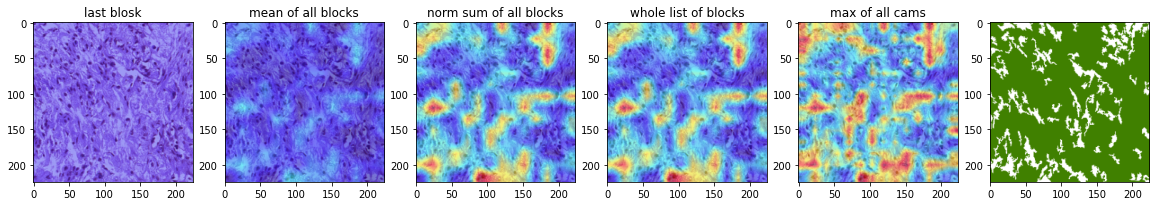

In [ ]:
fig = plt.figure(figsize=(20, 15))

ax = fig.add_subplot(2, 6, 1)
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_0[0, :], use_rgb=True))     # from just the last block
ax.set_title('last blosk')

ax = fig.add_subplot(2, 6, 2)
plt.imshow(show_cam_on_image(valid_img/255, test_cam_mean[0, :], use_rgb=True))   # mean of the cams from all blocks
ax.set_title('mean of all blocks')

ax = fig.add_subplot(2, 6, 3)
plt.imshow(show_cam_on_image(valid_img/255, ((test_cam_sum - np.min(test_cam_sum))/np.ptp(test_cam_sum))[0, :], use_rgb=True)) # Normalized sum of all cams
ax.set_title('norm sum of all blocks')

ax = fig.add_subplot(2, 6, 4)
plt.imshow(show_cam_on_image(valid_img/255, test_cams_0[0, :], use_rgb=True))     # passing the whole list of layers
ax.set_title('whole list of blocks')

ax = fig.add_subplot(2, 6, 5)
plt.imshow(show_cam_on_image(valid_img/255, test_cam_max, use_rgb=True))     # max of all cams
ax.set_title('max of all cams')

ax = fig.add_subplot(2, 6, 6)
plt.imshow(cv2.cvtColor(valid_mask, cv2.COLOR_BGR2RGB))

### Class 1: Stroma

In [ ]:
t_ls_0 = [x.norm1 for x in model_vit_base_patch16_224.blocks]
#t_ls_0

In [ ]:
t_ls = [[x.norm1] for x in model_vit_base_patch16_224.blocks]
#t_ls

In [ ]:
cams_0 = GradCAM(model = model_vit_base_patch16_224, target_layers=t_ls_0, reshape_transform=reshape_transform)

In [ ]:
cams = [GradCAM(model = model_vit_base_patch16_224, target_layers=x, reshape_transform=reshape_transform) for x in t_ls]

In [ ]:
test_cams = [x(input_tensor=valid_img_tensor, targets=[ClassifierOutputTarget(np.array([1]))]) for x in cams]
test_cams_0 = cams_0(input_tensor=valid_img_tensor, targets=[ClassifierOutputTarget(np.array([1]))])

In [ ]:
test_cam_mean = np.mean(np.array(test_cams), axis = 0)
test_cam_sum = np.array(test_cams).sum(axis=0)

In [ ]:
test_cam_max = np.vstack(test_cams).max(axis=0)

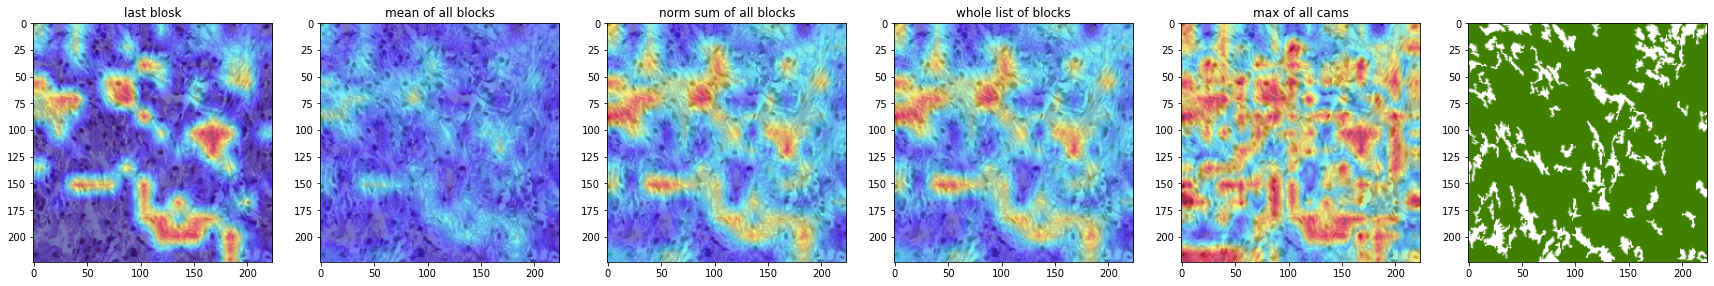

In [ ]:
fig = plt.figure(figsize=(30, 15))

ax = fig.add_subplot(2, 6, 1)
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_1[0, :], use_rgb=True))     # from just the last block
ax.set_title('last blosk')

ax = fig.add_subplot(2, 6, 2)
plt.imshow(show_cam_on_image(valid_img/255, test_cam_mean[0, :], use_rgb=True))   # mean of the cams from all blocks
ax.set_title('mean of all blocks')

ax = fig.add_subplot(2, 6, 3)
plt.imshow(show_cam_on_image(valid_img/255, ((test_cam_sum - np.min(test_cam_sum))/np.ptp(test_cam_sum))[0, :], use_rgb=True)) # Normalized sum of all cams
ax.set_title('norm sum of all blocks')

ax = fig.add_subplot(2, 6, 4)
plt.imshow(show_cam_on_image(valid_img/255, test_cams_0[0, :], use_rgb=True))     # passing the whole list of layers
ax.set_title('whole list of blocks')

ax = fig.add_subplot(2, 6, 5)
plt.imshow(show_cam_on_image(valid_img/255, test_cam_max, use_rgb=True))     # max of all cams
ax.set_title('max of all cams')

ax = fig.add_subplot(2, 6, 6)
plt.imshow(cv2.cvtColor(valid_mask, cv2.COLOR_BGR2RGB))

### Class 2: Normal

In [ ]:
t_ls_0 = [x.norm1 for x in model_vit_base_patch16_224.blocks]
#t_ls_0

In [ ]:
t_ls = [[x.norm1] for x in model_vit_base_patch16_224.blocks]
#t_ls

In [ ]:
cams_0 = GradCAM(model = model_vit_base_patch16_224, target_layers=t_ls_0, reshape_transform=reshape_transform)

In [ ]:
cams = [GradCAM(model = model_vit_base_patch16_224, target_layers=x, reshape_transform=reshape_transform) for x in t_ls]

In [ ]:
test_cams = [x(input_tensor=valid_img_tensor, targets=[ClassifierOutputTarget(np.array([2]))]) for x in cams]
test_cams_0 = cams_0(input_tensor=valid_img_tensor, targets=[ClassifierOutputTarget(np.array([2]))])

In [ ]:
test_cam_mean = np.mean(np.array(test_cams), axis = 0)
test_cam_sum = np.array(test_cams).sum(axis=0)

In [ ]:
test_cam_max = np.vstack(test_cams).max(axis=0)

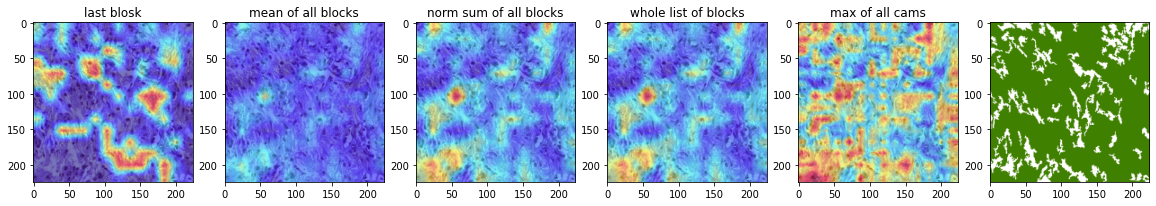

In [ ]:
fig = plt.figure(figsize=(20, 15))

ax = fig.add_subplot(2, 6, 1)
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_1[0, :], use_rgb=True))     # from just the last block
ax.set_title('last blosk')

ax = fig.add_subplot(2, 6, 2)
plt.imshow(show_cam_on_image(valid_img/255, test_cam_mean[0, :], use_rgb=True))   # mean of the cams from all blocks
ax.set_title('mean of all blocks')

ax = fig.add_subplot(2, 6, 3)
plt.imshow(show_cam_on_image(valid_img/255, ((test_cam_sum - np.min(test_cam_sum))/np.ptp(test_cam_sum))[0, :], use_rgb=True)) # Normalized sum of all cams
ax.set_title('norm sum of all blocks')

ax = fig.add_subplot(2, 6, 4)
plt.imshow(show_cam_on_image(valid_img/255, test_cams_0[0, :], use_rgb=True))     # passing the whole list of layers
ax.set_title('whole list of blocks')

ax = fig.add_subplot(2, 6, 5)
plt.imshow(show_cam_on_image(valid_img/255, test_cam_max, use_rgb=True))     # max of all cams
ax.set_title('max of all cams')

ax = fig.add_subplot(2, 6, 6)
plt.imshow(cv2.cvtColor(valid_mask, cv2.COLOR_BGR2RGB))

# Img 3

In [ ]:
valid_img_path = '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Dataset/WSSS4LUAD/2.validation/2.validation/img/02.png'
valid_mak_path = '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Dataset/WSSS4LUAD/2.validation/2.validation/mask/02.png'

In [ ]:
valid_img = cv2.resize(cv2.imread(valid_img_path), (224, 224))
valid_mask = cv2.resize(cv2.imread(valid_mak_path), (224, 224))

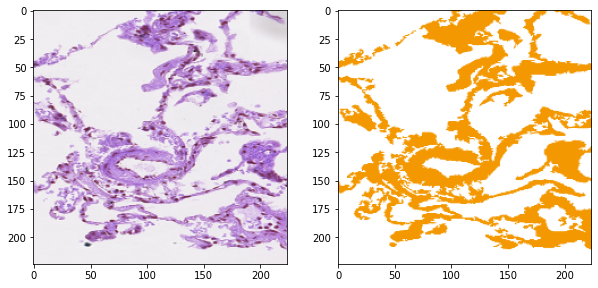

In [ ]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(1, 2, 1)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(valid_mask, cv2.COLOR_BGR2RGB))

In [ ]:
valid_img_tensor = preprocess_image(valid_img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]).to(device)

## 02. GradCAM: img 1

In [ ]:
cam = GradCAM(model = model_vit_base_patch16_224, target_layers=target_layer,
              reshape_transform=reshape_transform)

### Class 0: Tumor

In [ ]:
valid_cam_0 = cam(input_tensor=valid_img_tensor, targets=[ClassifierOutputTarget(np.array([0]))])
valid_cam_1 = cam(input_tensor=valid_img_tensor, targets=[ClassifierOutputTarget(np.array([1]))])
valid_cam_2 = cam(input_tensor=valid_img_tensor, targets=[ClassifierOutputTarget(np.array([2]))])

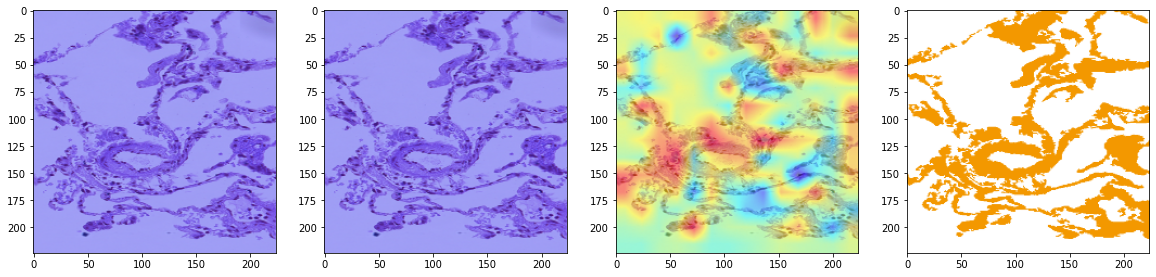

In [ ]:
fig = plt.figure(figsize=(20, 40))
'''
ax = fig.add_subplot(1, 4, 1)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 4, 2)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 4, 3)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 4, 4)
plt.imshow(valid_img)
'''
ax = fig.add_subplot(1, 4, 1)
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_0[0, :], use_rgb=True))

ax = fig.add_subplot(1, 4, 2)
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_1[0, :], use_rgb=True))

ax = fig.add_subplot(1, 4, 3)
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_2[0, :], use_rgb=True))

ax = fig.add_subplot(1, 4, 4)
plt.imshow(cv2.cvtColor(valid_mask, cv2.COLOR_BGR2RGB))

In [ ]:
t_ls_0 = [x.norm1 for x in model_vit_base_patch16_224.blocks]
#t_ls_0

In [ ]:
t_ls = [[x.norm1] for x in model_vit_base_patch16_224.blocks]
#t_ls

In [ ]:
cams_0 = GradCAM(model = model_vit_base_patch16_224, target_layers=t_ls_0, reshape_transform=reshape_transform)

In [ ]:
cams = [GradCAM(model = model_vit_base_patch16_224, target_layers=x, reshape_transform=reshape_transform) for x in t_ls]

In [ ]:
test_cams = [x(input_tensor=valid_img_tensor, targets=[ClassifierOutputTarget(np.array([2]))]) for x in cams]
test_cams_0 = cams_0(input_tensor=valid_img_tensor, targets=[ClassifierOutputTarget(np.array([2]))])

In [ ]:
test_cam_mean = np.mean(np.array(test_cams), axis = 0)
test_cam_sum = np.array(test_cams).sum(axis=0)

In [ ]:
test_cam_max = np.vstack(test_cams).max(axis=0)

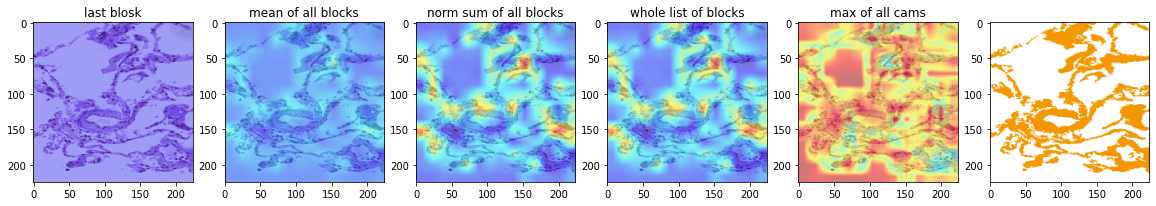

In [ ]:
fig = plt.figure(figsize=(20, 15))

ax = fig.add_subplot(2, 6, 1)
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_0[0, :], use_rgb=True))     # from just the last block
ax.set_title('last blosk')

ax = fig.add_subplot(2, 6, 2)
plt.imshow(show_cam_on_image(valid_img/255, test_cam_mean[0, :], use_rgb=True))   # mean of the cams from all blocks
ax.set_title('mean of all blocks')

ax = fig.add_subplot(2, 6, 3)
plt.imshow(show_cam_on_image(valid_img/255, ((test_cam_sum - np.min(test_cam_sum))/np.ptp(test_cam_sum))[0, :], use_rgb=True)) # Normalized sum of all cams
ax.set_title('norm sum of all blocks')

ax = fig.add_subplot(2, 6, 4)
plt.imshow(show_cam_on_image(valid_img/255, test_cams_0[0, :], use_rgb=True))     # passing the whole list of layers
ax.set_title('whole list of blocks')

ax = fig.add_subplot(2, 6, 5)
plt.imshow(show_cam_on_image(valid_img/255, test_cam_max, use_rgb=True))     # max of all cams
ax.set_title('max of all cams')

ax = fig.add_subplot(2, 6, 6)
plt.imshow(cv2.cvtColor(valid_mask, cv2.COLOR_BGR2RGB))

### Class 1: Stroma

In [ ]:
t_ls_0 = [x.norm1 for x in model_vit_base_patch16_224.blocks]
#t_ls_0

In [ ]:
t_ls = [[x.norm1] for x in model_vit_base_patch16_224.blocks]
#t_ls

In [ ]:
cams_0 = GradCAM(model = model_vit_base_patch16_224, target_layers=t_ls_0, reshape_transform=reshape_transform)

In [ ]:
cams = [GradCAM(model = model_vit_base_patch16_224, target_layers=x, reshape_transform=reshape_transform) for x in t_ls]

In [ ]:
test_cams = [x(input_tensor=valid_img_tensor, targets=[ClassifierOutputTarget(np.array([1]))]) for x in cams]
test_cams_0 = cams_0(input_tensor=valid_img_tensor, targets=[ClassifierOutputTarget(np.array([1]))])

In [ ]:
test_cam_mean = np.mean(np.array(test_cams), axis = 0)
test_cam_sum = np.array(test_cams).sum(axis=0)

In [ ]:
test_cam_max = np.vstack(test_cams).max(axis=0)

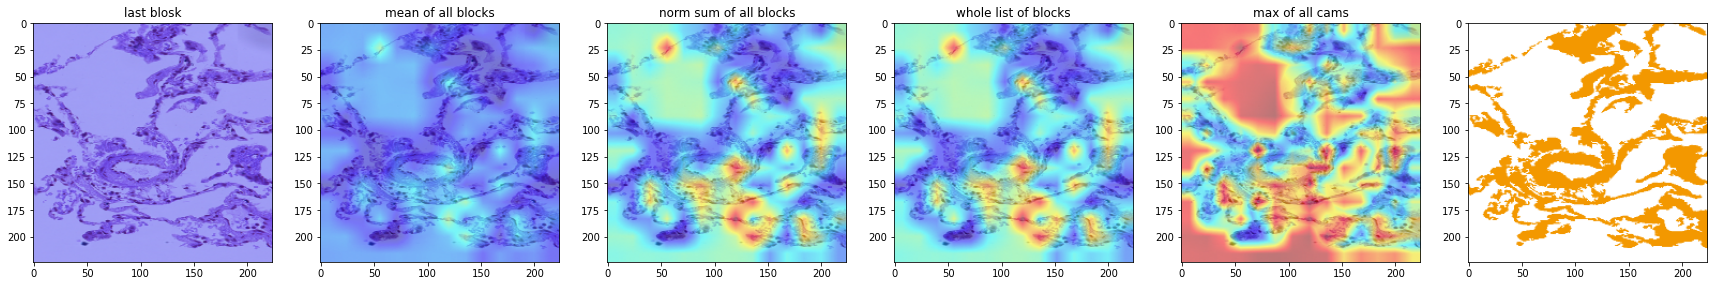

In [ ]:
fig = plt.figure(figsize=(30, 15))

ax = fig.add_subplot(2, 6, 1)
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_1[0, :], use_rgb=True))     # from just the last block
ax.set_title('last blosk')

ax = fig.add_subplot(2, 6, 2)
plt.imshow(show_cam_on_image(valid_img/255, test_cam_mean[0, :], use_rgb=True))   # mean of the cams from all blocks
ax.set_title('mean of all blocks')

ax = fig.add_subplot(2, 6, 3)
plt.imshow(show_cam_on_image(valid_img/255, ((test_cam_sum - np.min(test_cam_sum))/np.ptp(test_cam_sum))[0, :], use_rgb=True)) # Normalized sum of all cams
ax.set_title('norm sum of all blocks')

ax = fig.add_subplot(2, 6, 4)
plt.imshow(show_cam_on_image(valid_img/255, test_cams_0[0, :], use_rgb=True))     # passing the whole list of layers
ax.set_title('whole list of blocks')

ax = fig.add_subplot(2, 6, 5)
plt.imshow(show_cam_on_image(valid_img/255, test_cam_max, use_rgb=True))     # max of all cams
ax.set_title('max of all cams')

ax = fig.add_subplot(2, 6, 6)
plt.imshow(cv2.cvtColor(valid_mask, cv2.COLOR_BGR2RGB))

### Class 2: Normal

In [ ]:
t_ls_0 = [x.norm1 for x in model_vit_base_patch16_224.blocks]
#t_ls_0

In [ ]:
t_ls = [[x.norm1] for x in model_vit_base_patch16_224.blocks]
#t_ls

In [ ]:
cams_0 = GradCAM(model = model_vit_base_patch16_224, target_layers=t_ls_0, reshape_transform=reshape_transform)

In [ ]:
cams = [GradCAM(model = model_vit_base_patch16_224, target_layers=x, reshape_transform=reshape_transform) for x in t_ls]

In [ ]:
test_cams = [x(input_tensor=valid_img_tensor, targets=[ClassifierOutputTarget(np.array([2]))]) for x in cams]
test_cams_0 = cams_0(input_tensor=valid_img_tensor, targets=[ClassifierOutputTarget(np.array([2]))])

In [ ]:
test_cam_mean = np.mean(np.array(test_cams), axis = 0)
test_cam_sum = np.array(test_cams).sum(axis=0)

In [ ]:
test_cam_max = np.vstack(test_cams).max(axis=0)

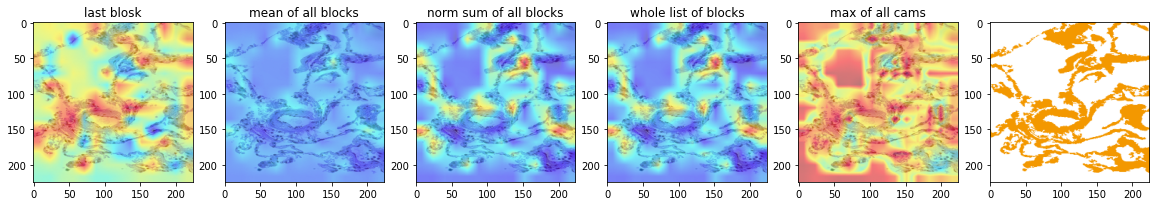

In [ ]:
fig = plt.figure(figsize=(20, 15))

ax = fig.add_subplot(2, 6, 1)
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_2[0, :], use_rgb=True))     # from just the last block
ax.set_title('last blosk')

ax = fig.add_subplot(2, 6, 2)
plt.imshow(show_cam_on_image(valid_img/255, test_cam_mean[0, :], use_rgb=True))   # mean of the cams from all blocks
ax.set_title('mean of all blocks')

ax = fig.add_subplot(2, 6, 3)
plt.imshow(show_cam_on_image(valid_img/255, ((test_cam_sum - np.min(test_cam_sum))/np.ptp(test_cam_sum))[0, :], use_rgb=True)) # Normalized sum of all cams
ax.set_title('norm sum of all blocks')

ax = fig.add_subplot(2, 6, 4)
plt.imshow(show_cam_on_image(valid_img/255, test_cams_0[0, :], use_rgb=True))     # passing the whole list of layers
ax.set_title('whole list of blocks')

ax = fig.add_subplot(2, 6, 5)
plt.imshow(show_cam_on_image(valid_img/255, test_cam_max, use_rgb=True))     # max of all cams
ax.set_title('max of all cams')

ax = fig.add_subplot(2, 6, 6)
plt.imshow(cv2.cvtColor(valid_mask, cv2.COLOR_BGR2RGB))